# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (`Vehicle_Detection.ipynb`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...


## Preperation and utilities
### Define Consts

In [1]:
MODE_GEN_FEATURES = False
MODE_TRAIN = False
MODE_EVAL = False

In [2]:
IMAGE_SUFFIX_JPG = ".jpeg"
IMAGE_SUFFIX_PNG = ".png"

In [3]:
TRAINING_IMAGE_SUFFIX = IMAGE_SUFFIX_JPG
DIR_TRAIN_DATA_SMALL = './sample_training_dataset/*_smallset/*/'

DIR_TRAIN_DATA_SMALL_VEHICLES = './sample_training_dataset/vehicles_smallset/*/'
DIR_TRAIN_DATA_SMALL_NON_VEHICLES = './sample_training_dataset/non-vehicles_smallset/*/'

DIR_TRAIN_DATA = DIR_TRAIN_DATA_SMALL + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_VEHICLES = DIR_TRAIN_DATA_SMALL_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_NON_VEHICLES = DIR_TRAIN_DATA_SMALL_NON_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
print(DIR_TRAIN_DATA)

./sample_training_dataset/*_smallset/*/*.jpeg


In [4]:
TRAINING_IMAGE_SUFFIX = IMAGE_SUFFIX_PNG
DIR_TRAIN_DATA_FULL = './sample_training_dataset/*_fullset/*/'

DIR_TRAIN_DATA_FULL_VEHICLES = './sample_training_dataset/vehicles_fullset/*/'
DIR_TRAIN_DATA_FULL_NON_VEHICLES = './sample_training_dataset/non-vehicles_fullset/*/'

DIR_TRAIN_DATA = DIR_TRAIN_DATA_FULL + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_VEHICLES = DIR_TRAIN_DATA_FULL_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_NON_VEHICLES = DIR_TRAIN_DATA_FULL_NON_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
print(DIR_TRAIN_DATA)

./sample_training_dataset/*_fullset/*/*.png


### Import Packages

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split

import pickle
import os

## Drawing Function
(from Manual Vehicle Detection: draw_bboxes.py)

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

### Histograms of Color

In [7]:
# from color_histogram.py
#Define a function to compute color histogram features  
def color_hist_demo(img, nbins=32, bins_range=(0, 256), vis=False):
    
    # Return the individual histograms, bin_centers and feature vectordef color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    if vis == True:
        # Generating bin centers
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features
    else:
        return hist_features

#### Color Histogram Demo

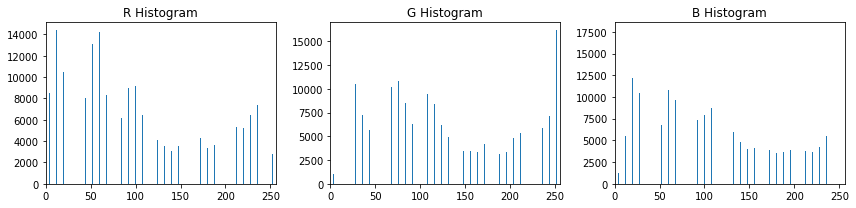

In [8]:
image = mpimg.imread('cutout1.jpg')
    
rh, gh, bh, bincen, feature_vec = color_hist_demo(image, nbins=32, bins_range=(0, 256), vis=True)

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

### Spatial Binning of Color

In [9]:
"""spatial_bin.py"""
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial_demo(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

#### Spatial Bining Demo

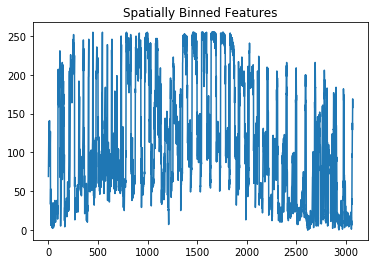

In [10]:
image = mpimg.imread('cutout1.jpg')
    
feature_vec = bin_spatial_demo(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

### Data Exploration


In [11]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [12]:
def load_images(dir_path):
    images = glob.glob(dir_path)
    files = []
    for image in images:
        files.append(image)

    print(len(files))
    if (len(files) == 0) :
        print("Empty data")

    return files

def load_train_data():
    cars = load_images(DIR_TRAIN_DATA_VEHICLES)
    notcars = load_images(DIR_TRAIN_DATA_NON_VEHICLES)
    return cars, notcars

8792
8968
8792 8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


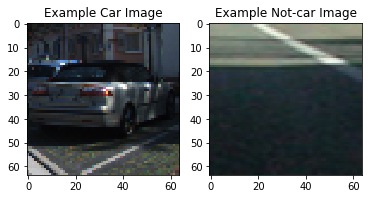

In [13]:
cars, notcars = load_train_data()

print(len(cars), len(notcars))
if (len(cars) != 0 and len(notcars) != 0) :
    data_info = data_look(cars, notcars)
else:
    print("Empty data")

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

#print(car_image)

### scikit-image HOG


In [14]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#### HOG Visualization Demo

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


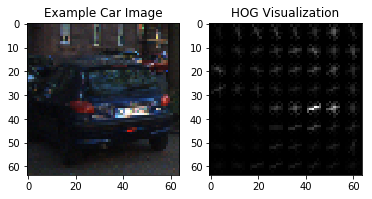

In [15]:
"""get_hog.py"""
# Read in our vehicles and non-vehicles

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

### Combine and Normalize Features

Norm_shuffle.py


In [16]:
def convert_color(img, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img)

In [17]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [18]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, 
                        hist_range=None,
                        orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion 
        feature_image = convert_color(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            if hist_range == None:
                 hist_features = color_hist(feature_image, nbins=hist_bins)
            else:
                # Apply color_hist() also with a color space option now
                hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [19]:
def dump_features(targets, nottargets):
    cur_dir = os.path.dirname(".")
    dest = os.path.join(cur_dir, 'pkl_objects')
    print(dest)
    if not os.path.exists(dest):
        os.mkdir(dest)
    pickle.dump(targets, open(os.path.join(dest, 'targets.pkl'), 'wb'), protocol=4)
    pickle.dump(nottargets, open(os.path.join(dest, 'nottargets.pkl'), 'wb'), protocol=4)

In [20]:
def load_features():
    cur_dir = os.path.dirname(".")
    src = os.path.join(cur_dir, 'pkl_objects')
    targets = pickle.load(open(os.path.join(src, 'targets.pkl'), 'rb'))
    nottargets = pickle.load(open(os.path.join(src, 'nottargets.pkl'), 'rb'))
    return targets, nottargets

In [21]:
# THESE DUMPS ARE NOT USED FOR TRAINING BUT DEMO ONLY NOW
if MODE_GEN_FEATURES == True:
    car_features = extract_features(cars, color_space='RGB',#cspace='RGB', 
                                spatial_size=(16, 16),#spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
    notcar_features = extract_features(notcars, color_space='RGB',#cspace='RGB', 
                                   spatial_size=(16, 16),#spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
    dump_features(car_features, notcar_features)
else:
    car_features, notcar_features = load_features()
    print("Use dumped features")

Use dumped features


#### Features Normalization Demo

8792
8968


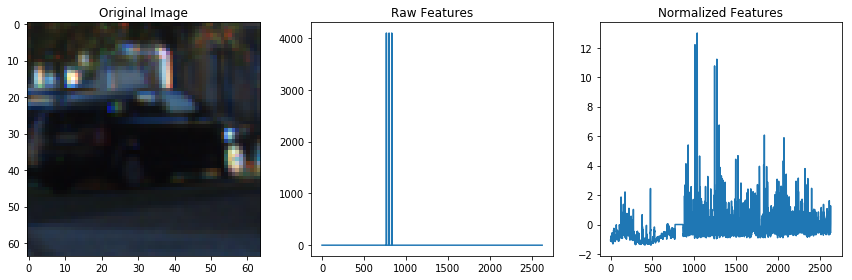

In [22]:
print(len(car_features))
print(len(notcar_features))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### Parameter Tuning

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]

In [23]:
"""based on sliding_window.py"""

"""
solution.py
"""
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Search and Classify
Search_classify.py


lesson_function.py

In [24]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [25]:
"""
solution.py
"""
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [26]:
def single_img_features_w_config(img, config):
    color_space=config.color_space 
    spatial_size=config.spatial_size
    hist_bins=config.hist_bins
    orient=config.orient
    pix_per_cell=config.pix_per_cell 
    cell_per_block=config.cell_per_block 
    hog_channel=config.hog_channel
    spatial_feat=config.spatial_feat 
    hist_feat=config.hist_feat
    hog_feat=config.hog_feat
    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows_w_config(img, windows, clf, scaler, config):

    color_space=config.color_space 
    spatial_size=config.spatial_size
    hist_bins=config.hist_bins
    orient=config.orient
    pix_per_cell=config.pix_per_cell 
    cell_per_block=config.cell_per_block 
    hog_channel=config.hog_channel
    spatial_feat=config.spatial_feat 
    hist_feat=config.hist_feat
    hog_feat=config.hog_feat
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Features Extraction
=============================================================================

### Linear SVC

https://discussions.udacity.com/t/white-cars-aargh/227914/14

color_space = YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32) 
hist_bins = 32
spatial_feat = True 
hist_feat = True 
hog_feat = True

threshold = 3
scales of 1. and 1.5 ????????????????????????
The heatmap number of frames in a deque to average = 10.

The cars list is from the Udacity vehicles dataset.
The notcars list is from the Udacity non-vehicles dataset.

### Class and Function Definition

In [27]:
"""
Recomendation from Forum
cspace = 'HSV' # RGB, HSV, LUV, HLS, YUV or YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 1 # 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

"""
class Config():
    def __init__(self, color_space, 
                            spatial_size= (16,16), hist_bins=16, 
                            orient=9, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', 
                            spatial_feat=True, 
                            hist_feat=True, hog_feat=True):
        self.color_space=color_space 
        self.spatial_size=spatial_size
        self.hist_bins=hist_bins
        self.orient=orient
        self.pix_per_cell=pix_per_cell 
        self.cell_per_block=cell_per_block 
        self.hog_channel=hog_channel
        self.spatial_feat=spatial_feat 
        self.hist_feat=hist_feat
        self.hog_feat=hog_feat
    def desc(self):
        return self.color_space + ", hog cannel={}, hist_bins={}".format(self.hog_channel, self.hist_bins)

def train_svc(config, targets, nottargets, eval=False):
    color_space=config.color_space 
    spatial_size=config.spatial_size
    hist_bins=config.hist_bins
    orient=config.orient
    pix_per_cell=config.pix_per_cell 
    cell_per_block=config.cell_per_block 
    hog_channel=config.hog_channel
    spatial_feat=config.spatial_feat 
    hist_feat=config.hist_feat
    hog_feat=config.hog_feat
        
    target_features = extract_features(targets, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    nottarget_features = extract_features(nottargets, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((target_features, nottarget_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(target_features)), np.zeros(len(nottarget_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
       'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))


    if eval == True:
        return X_train, y_train
    else:
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
        print('')
        return svc, X_scaler

In [28]:
def train_svc_w_features(target_features, nottarget_features, eval=False):

    X = np.vstack((target_features, nottarget_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(target_features)), np.zeros(len(nottarget_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    #print('Using:',orient,'orientations',pix_per_cell,
    #    'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))


    if eval == True:
        return X_train, y_train
    else:
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
        print('')
        return svc, X_scaler

In [29]:
def prep_training(target_features, nottarget_features):

    X = np.vstack((target_features, nottarget_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(target_features)), np.zeros(len(nottarget_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    #print('Using:',orient,'orientations',pix_per_cell,
    #    'pixels per cell and', cell_per_block,'cells per block')
    #print('Feature vector length:', len(X_train[0]))
    
    return X_train, y_train, X_test, y_test, X_scaler

def train_linear_svc(X_train, y_train, X_test, y_test):
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    print('')
    return svc

In [30]:
def dump_trained(clr, scaler, config):
    cur_dir = os.path.dirname(".")
    dest = os.path.join(cur_dir, 'pkl_objects')
    print(dest)
    if not os.path.exists(dest):
        os.mkdir(dest)
    pickle.dump(clr, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)
    pickle.dump(scaler, open(os.path.join(dest, 'scaler.pkl'), 'wb'), protocol=4)
    pickle.dump(config, open(os.path.join(dest, 'config.pkl'), 'wb'), protocol=4)

In [31]:
def load_trained():
    cur_dir = os.path.dirname(".")
    src = os.path.join(cur_dir, 'pkl_objects')
    clr = pickle.load(open(os.path.join(src, 'classifier.pkl'), 'rb'))
    scaler = pickle.load(open(os.path.join(src, 'scaler.pkl'), 'rb'))
    config = pickle.load(open(os.path.join(src, 'config.pkl'), 'rb'))
    return clr, scaler, config

#### Training Execution

"""
Recomendation from Forum
* cspace = 'HSV' # RGB, HSV, LUV, HLS, YUV or YCrCb
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 1 # 0, 1, 2, or "ALL"
* spatial_size = (16,16) # Spatial binning dimensions
* hist_bins = 16
* spatial_feat = True # Spatial features on or off
* hist_feat = True # Histogram features on or off
* hog_feat = True # HOG features on or off

"""
### Tweak these parameters and see how the results change.
* color_space ='HSV' # 'HLS' #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
* orient = 9  # HOG orientations
* pix_per_cell = 8 # HOG pixels per cell
* cell_per_block = 2 # HOG cells per block
* hog_channel = "ALL"#1 # "ALL" #0 # Can be 0, 1, 2, or "ALL"
* spatial_size = (16, 16) # Spatial binning dimensions
* hist_bins = 16#32#16#32 #16    # Number of histogram bins
* spatial_feat = True # Spatial features on or off
* hist_feat = True # Histogram features on or off
* hog_feat = True # HOG features on or off
* y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [32]:
def set_config():
    config = Config(color_space ='HSV', 
                            spatial_size= (16,16), hist_bins=16, 
                            orient=9, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel="ALL", 
                            spatial_feat=True, 
                            hist_feat=True, hog_feat=True)
    return config

In [33]:
if MODE_TRAIN == True:
    config = set_config()
    clr, scaler = train_svc(config, cars, notcars)
    dump_trained(clr, scaler, config)
else:
    clr, scaler, config = load_trained()
        
    print("Use dumped data")

Use dumped data


In [34]:
#cspace = 'HSV' # RGB, HSV, LUV, HLS, YUV or YCrCb
config_list = [#
    #Config('RGB'),Config('RGB',hog_channel = 'ALL'), 
    #Config('HSV'),Config('HSV',hog_channel = 'ALL') ,Config('HSV',hog_channel = 'ALL', hist_bins = 32)  ,
    #Config('LUV'),Config('LUV',hog_channel = 'ALL') ,
    #Config('HLS'),Config('HLS',hog_channel = 'ALL') ,
    #Config('YUV'),Config('YUV',hog_channel = 'ALL'),
    #Config('YCrCb'),Config('YCrCb',hog_channel = 'ALL')
    ]
svc_list = []
for config in config_list:
    print(config.desc())
    svc_list.append(train_svc(config))

print(len(svc_list))

0


In [35]:
# feasibility check
svc = clr
X_scaler = scaler

### Cross-validation with GridSearchCV

In [36]:
from sklearn import svm, grid_search
def eval_parameters(X_train, y_train):
    """Cross-validation with GridSearchCV"""
    svr = svm.SVC()
    grid_search = grid_search.GridSearchCV(svr, tuned_parameters, cv=5)

    t=time.time()
    grid_search.fit(X_train, y_train) 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC(with GridSearchCV)...')
    print(grid_search.grid_scores_)
    print(grid_search.grid_scores_)
    print(grid_search.grid_scores_)

C:\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [37]:
tuned_parameters = {'kernel':['linear'], 'C':[0.1, 1,10]}
if MODE_EVAL == True:
    config = set_config()
    #X_train, y_train = train_svc(config, cars, notcars, eval=True)
    X_train, y_train =train_svc_w_features(car_features, notcar_features, eval=True)
    eval_parameters(X_train, y_train)

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

print(hot_windows)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [38]:
def prit_parameters(color_space, 
                        spatial_size, hist_bins, 
                        orient, pix_per_cell, 
                        cell_per_block,
                        hog_channel, spatial_feat, 
                        hist_feat, hog_feat):
    print("color_space",color_space) 

    print("hist_bins",hist_bins) 
    print("orient",orient)
    print("pix_per_cell",pix_per_cell) 
    print("cell_per_block",cell_per_block)
    print("hog_channel",hog_channel) 
    print("spatial_feat",spatial_feat) 
    print("spatial_size",spatial_size)
    print("hist_feat",hist_feat)
    print("hog_feat",hog_feat)

In [39]:
def print_global_variables():
    print("color_space",color_space) 

    print("orient",orient) 

    print("pix_per_cell",pix_per_cell) 
    print("cell_per_block",cell_per_block)
 
    #print("spatial_feat",spatial_feat) 
    #print("spatial_size",spatial_size)
    
    #print("hist_feat",hist_feat)
    #print("hist_bins",hist_bins) 
   
    
    #print("hog_feat",hog_feat)
    #print("hog_channel",hog_channel)
    
    #print("scale", scale)

In [40]:
color_space = "RGB"
print_global_variables()

SIZE_RANGES = (64, 128, 256)
Y_END_RATES = (0.7, 0.8, 1)
XY_OVERLAP = (0.7, 0.7)

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)


svc = svc
X_scaler = X_scaler

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    image = image.astype(np.float32)/255

#print(image)
x_start_stop = [None, None]
y_start_stop = [image.shape[0]//2, image.shape[0]]

windows = []
for y_end, xysize in zip(Y_END_RATES, SIZE_RANGES):
    size = (xysize, xysize)
    y_start_stop = [image.shape[0]//2, int(y_end*image.shape[0])]
    windows.extend(slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=size, xy_overlap=XY_OVERLAP))

    print(size, y_start_stop)

#hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space)#, 
                        #spatial_size=spatial_size, hist_bins=hist_bins, 
                        #orient=orient, pix_per_cell=pix_per_cell, 
                        #cell_per_block=cell_per_block,
                        #hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        #hist_feat=hist_feat, hog_feat=hog_feat)  
"""
prit_parameters(color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
"""

#window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

#plt.imshow(window_img)


color_space RGB
orient 9
pix_per_cell 8
cell_per_block 2
(64, 64) [360, 503]
(128, 128) [360, 576]
(256, 256) [360, 720]


'\nprit_parameters(color_space=color_space, \n                        spatial_size=spatial_size, hist_bins=hist_bins, \n                        orient=orient, pix_per_cell=pix_per_cell, \n                        cell_per_block=cell_per_block,\n                        hog_channel=hog_channel, spatial_feat=spatial_feat, \n                        hist_feat=hist_feat, hog_feat=hog_feat)\n'

### Multiple Detections & False Positives

In [41]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Heat Map

In [42]:
color_space ='HSV'
spatial_size= (16,16)
hist_bins=16
orient=9
pix_per_cell=8 
cell_per_block=2
hog_channel="ALL"
spatial_feat=True
hist_feat=True
hog_feat=True

image was modified.
(64, 64) [360, 503]
(128, 128) [360, 576]
(256, 256) [360, 720]


C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


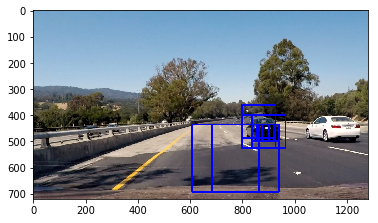

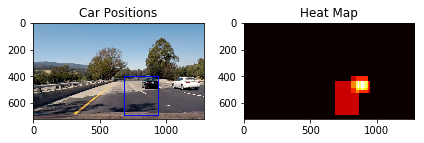

In [43]:
# Read in image similar to one shown above 
#image = mpimg.imread("bbox-example-image.jpg")#('test_image.jpg')
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
search_image = np.copy(image)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    print("image was modified.")
    search_image = search_image.astype(np.float32)/255

x_start_stop = [None, None]
y_start_stop = [image.shape[0]//2, image.shape[0]]

windows = []
for y_end, xysize in zip(Y_END_RATES, SIZE_RANGES):
    size = (xysize, xysize)
    y_start_stop = [image.shape[0]//2, int(y_end*image.shape[0])]
    windows.extend(slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=size, xy_overlap=XY_OVERLAP))

    print(size, y_start_stop)

hot_windows = search_windows(search_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,hot_windows)#ox_list)

#print(heat)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [44]:
def process_search(image, viz=False):
    search_image = np.copy(image)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        search_image = search_image.astype(np.float32)/255
    
    hot_windows = search_windows(search_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
    # ignore heatmap
    draw_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6) 
    if viz == True:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        fig.tight_layout()
    return draw_img

# Assuming Global Variables: windows, svc, X_scaler
# and heatmaps
import collections
heatmaps = collections.deque(maxlen=14)
def process_heatmap(image, threshold=3, viz=False):
    search_image = np.copy(image)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        search_image = search_image.astype(np.float32)/255
    
    hot_windows = search_windows(search_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  

    #draw_img = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Use deque 
    #heatmaps.append(heat)
    #heatmap_sum = sum(heatmaps)
    #thresh_heat = apply_threshold(heatmap_sum, threshold)
    if heatmaps == None:
        # Apply threshold to help remove false positives
        thresh_heat = apply_threshold(heat,threshold)
    else:
        if heatmaps.maxlen == 1:
            thresh_heat = apply_threshold(heat,threshold)
        else:
            heatmaps.append(heat)
            heatmap_sum = sum(heatmaps)
            thresh_heat = apply_threshold(heatmap_sum, threshold)

    labels = label(thresh_heat)
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,threshold)
    thresh_heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    #labels = label(heatmap)
    labels = label(thresh_heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if viz == True:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map {}'.format(threshold))
        fig.tight_layout()

    return draw_img

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


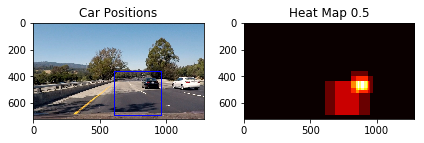

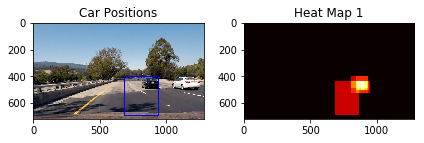

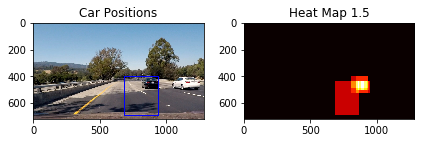

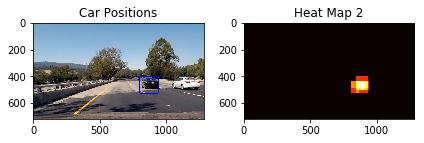

In [45]:
image = mpimg.imread('test_images/test4.jpg')

draw_img = process_heatmap(image, 0.5, viz=True)
draw_img = process_heatmap(image, 1, viz=True)
draw_img = process_heatmap(image, 1.5, viz=True)
draw_img = process_heatmap(image, 2, viz=True)
#draw_img = process_heatmap(image, 3, viz=True)
#draw_img = process_heatmap(image, 4, viz=True)
#draw_img = process_search(image, viz=True)

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


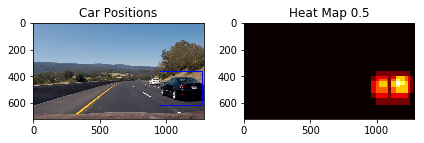

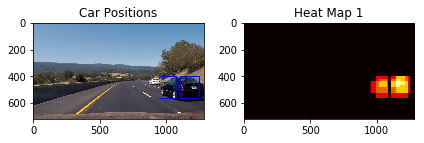

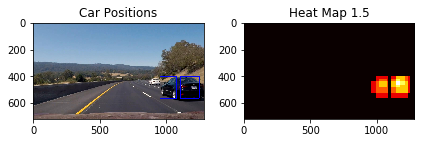

In [47]:
image = mpimg.imread('target_images/black_car_large.jpg')
        
draw_img = process_heatmap(image, 0.5, viz=True)
draw_img = process_heatmap(image, 1, viz=True)
draw_img = process_heatmap(image, 1.5, viz=True)
#draw_img = process_heatmap(image, 2, viz=True)
#draw_img = process_heatmap(image, 3, viz=True)
#draw_img = process_search(image)

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


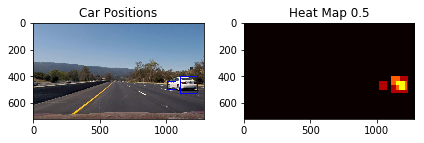

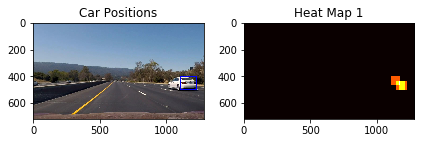

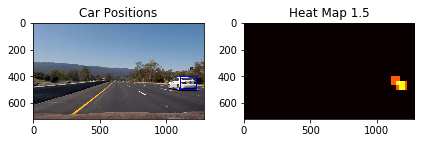

In [48]:
image = mpimg.imread('target_images/white_car_small.jpg')
        
draw_img = process_heatmap(image, 0.5, viz=True)
draw_img = process_heatmap(image, 1, viz=True)
draw_img = process_heatmap(image, 1.5, viz=True)
#draw_img = process_heatmap(image, 2, viz=True)
#draw_img = process_heatmap(image, 3, viz=True)
#draw_img = process_heatmap(image, 4, viz=True)
#draw_img = process_search(image)

# End of Preparation



# -------------------------------------------------------------------
### Hog Sub-sampling Window Search
Hog_subsample.py


In [50]:
def show_two_images(img1, img2, title1="Original Image", title2="Result Image"):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [51]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz=False):
    
    draw_img = np.copy(img)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        #search_image = search_image.astype(np.float32)/255
        img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    if viz == True:
        print("len(img_tosearch)",len(img_tosearch))
        print("len(draw_img)",len(draw_img))
        plt.imshow(img_tosearch)
    
        
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    if viz == True:
        print("len(ctrans_tosearch)",len(ctrans_tosearch))
        plt.imshow(ctrans_tosearch)

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [72]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def process_find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz=False):
    
    draw_img = np.copy(img)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        #search_image = search_image.astype(np.float32)/255
        img = img.astype(np.float32)/255
    img_tosearch = np.copy(img) 
    img_tosearch = img[ystart:ystop,:,:]
    #if viz == True:
    #    print("len(img_tosearch)",len(img_tosearch))
    #    print("len(draw_img)",len(draw_img))
    #    show_two_images(draw_img, img_tosearch)

    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')#
    #2) Apply color conversion if other than 'RGB'
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)


    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    if viz == True:
        show_two_images(draw_img, ctrans_tosearch)
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            #3) Extract the test window from original image
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            #4) Extract features for that window NOT using single_img_features() but hog, and spatial and hist separately
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            
            #5) Scale extracted features to be fed to classifier
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))   
            
            #6) Predict using your classifier
            test_prediction = svc.predict(test_features)
            
            #7) If positive (prediction == 1) then save the window
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                    
                if viz == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                # Calculate window position
                startx = xbox_left
                starty = ytop_draw+ystart
                
                endx = xbox_left+win_draw
                endy = ytop_draw+win_draw+ystart

                on_windows.append(((startx, starty), (endx, endy)))
    
    #8) Return windows for positive detections
    #if viz == True:
        #show_two_images(img, draw_img)
        
    return on_windows            
    #return draw_img

In [73]:
# Assuming Global Variables: windows, svc, X_scaler
# and heatmaps
import collections
heatmaps = collections.deque(maxlen=14)
def process_heatmap_hog_sub_sample(image, config, threshold, scale, viz=False):
    
    #config.hog_channel="ALL", 
    #config.spatial_feat=True, 
    #config.hist_feat=True
    #config.hog_feat=True
    
    #ystart, ystop, svc, X_scaler,

    color_space = config.color_space
    orient = config.orient 
    pix_per_cell = config.pix_per_cell
    cell_per_block = config.cell_per_block 
    spatial_size = config.spatial_size 
    hist_bins = config.hist_bins
    
    search_image = np.copy(image)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        search_image = search_image.astype(np.float32)/255
    
    hot_windows = process_find_cars(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz)
    
    #draw_img = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Use deque 
    if heatmaps == None:
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,threshold)
    else:
        if heatmaps.maxlen == 1:
            heat = apply_threshold(heat,threshold)
        else:
            heatmaps.append(heat)
            heatmap_sum = sum(heatmaps)
            heat = apply_threshold(heatmap_sum, threshold)
        

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if viz == True:        
        draw_img = draw_boxes(np.copy(draw_img), hot_windows, color=(0, 255,0), thick=2)
        
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions (scale:{})'.format(scale))
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map (thres:{})'.format(threshold))
        fig.tight_layout()
        

    return draw_img

In [145]:
def process_heatmap_hog_sub_sample_w_scales(image, config, threshold, scales, ystart, ystop, vis=False):

    color_space = config.color_space
    orient = config.orient 
    pix_per_cell = config.pix_per_cell
    cell_per_block = config.cell_per_block 
    spatial_size = config.spatial_size 
    hist_bins = config.hist_bins
    
    search_image = np.copy(image)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        search_image = search_image.astype(np.float32)/255
    
    hot_windows = []

    devides = len(scales)
    devide_heights = (ystop - ystart)//devides
    for i in range(devides):
        start_y = ystart# + devide_heights *(i)
        stop_y = start_y + devide_heights*(i+1)#devide_heights
        if vis == True: 
            print("iteration",i)
            print("start_y",start_y)
            print("stop_y",stop_y)
        on_windows = process_find_cars(image, start_y, stop_y, scales[i], svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis)
        hot_windows.extend(on_windows)
        
    #draw_img = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Use deque 
    if heatmaps == None:
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,threshold)
    else:
        if heatmaps.maxlen == 1:
            heat = apply_threshold(heat,threshold)
        else:
            heatmaps.append(heat)
            heatmap_sum = sum(heatmaps)
            heat = apply_threshold(heatmap_sum, threshold)
        

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if vis == True:        
        draw_img = draw_boxes(np.copy(draw_img), hot_windows, color=(0, 255,0), thick=2)
        
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions (scale:{})'.format(scales))
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map (thres:{})'.format(threshold))
        fig.tight_layout()
        

    return draw_img

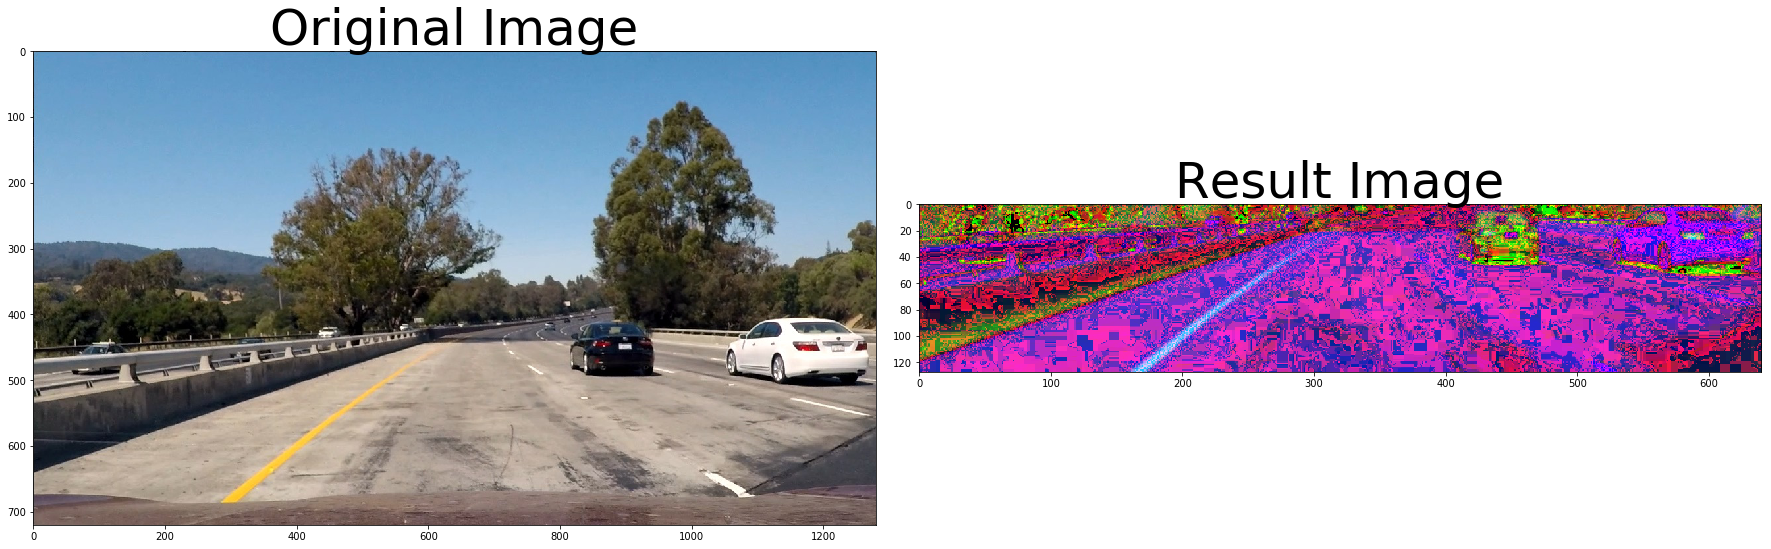

In [110]:

img = mpimg.imread("./test_images/test1.jpg")

ystart = img.shape[0]//2
ystop = img.shape[0]

#print(ystart, ystop)

ystart = 400
ystop = 656
scale = 2#1.5#1.5
    
#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz=True)
#def process_find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz=False):

_ = process_find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, viz=True)

#plt.imshow(out_img)


0.67 Seconds to process a frame...


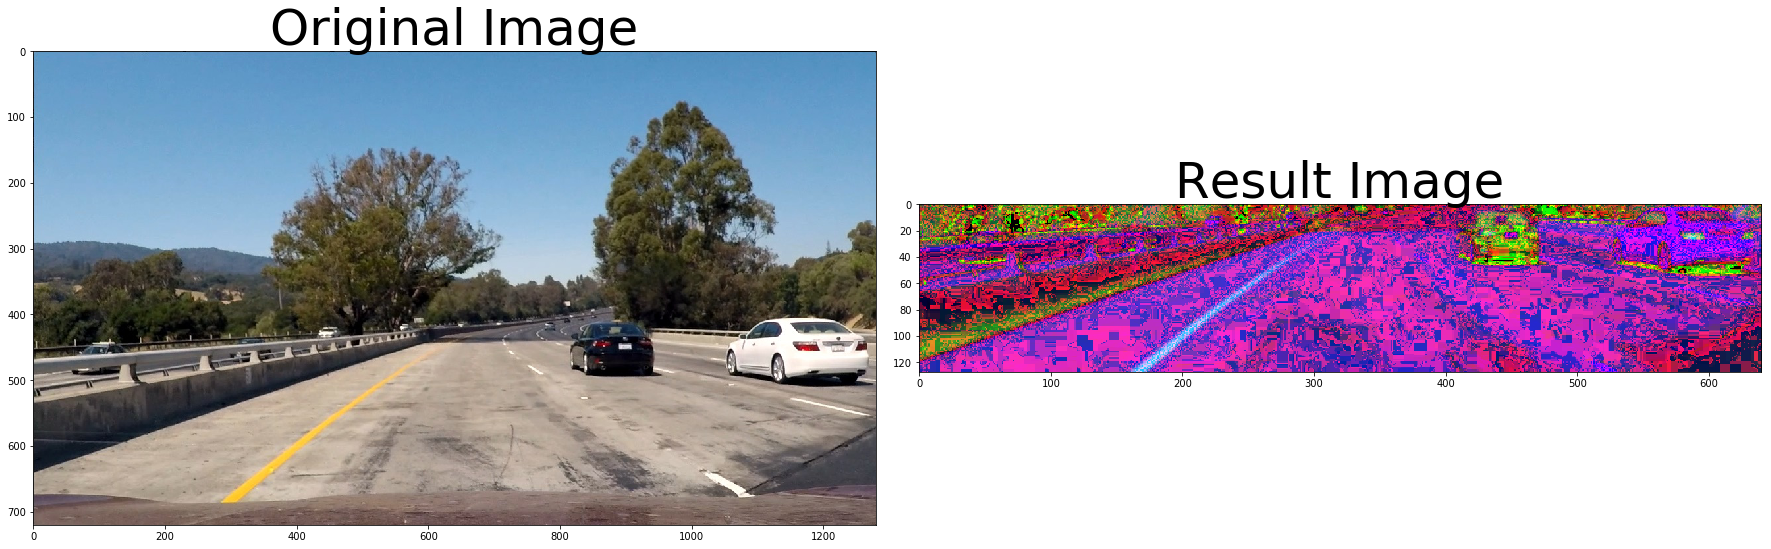

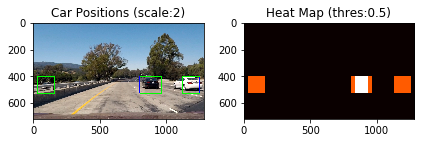

In [111]:
image = mpimg.imread('test_images/test1.jpg')

t=time.time()

heatmaps = collections.deque(maxlen=1)
draw_img = process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=2, viz=True)
#draw_img = process_search(image)
heatmaps = None

t2 = time.time()
print(round(t2-t, 2), 'Seconds to process a frame...')

1.57 Seconds to process a frame...


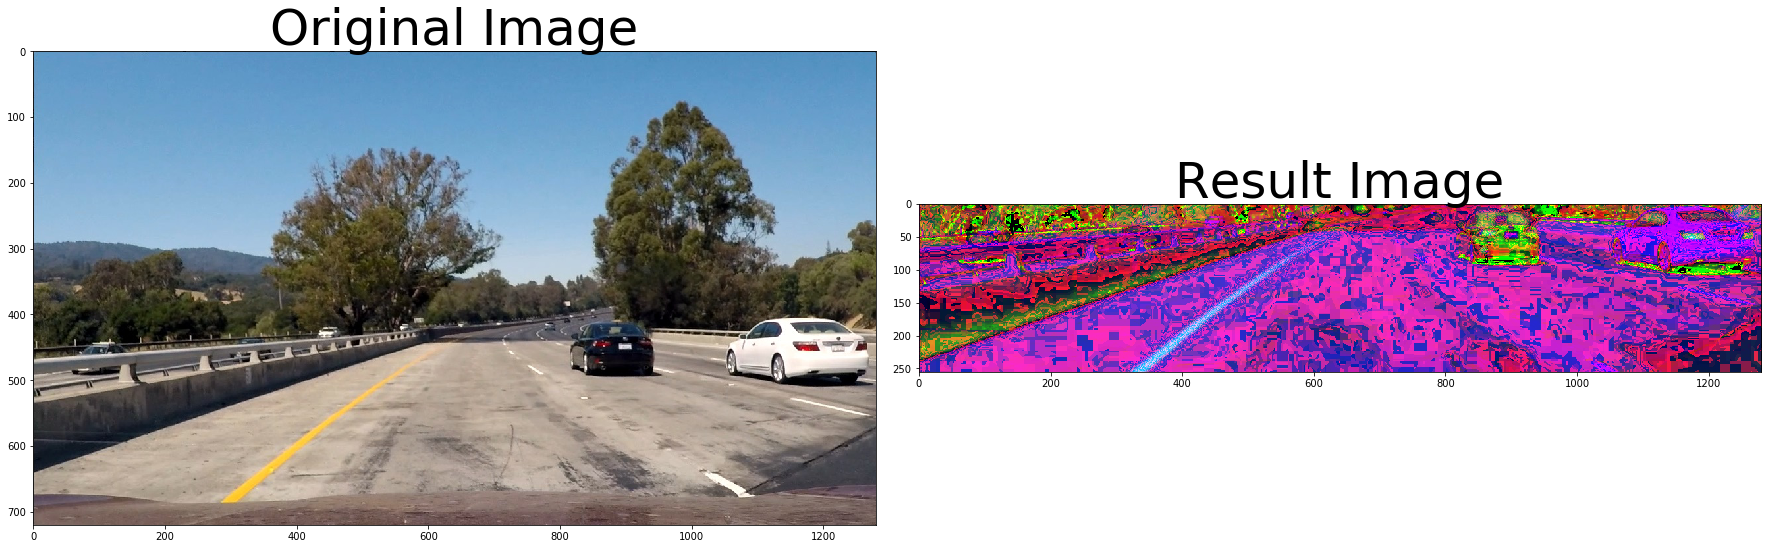

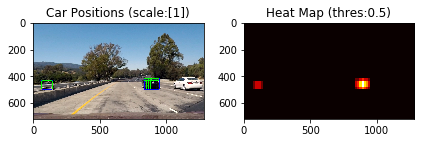

In [112]:
image = mpimg.imread('test_images/test1.jpg')

t=time.time()

heatmaps = collections.deque(maxlen=1)

scales = [1]
threshold=0.5
process_heatmap_hog_sub_sample_w_scales(image, config, threshold, scales, ystart, ystop, vis=True)

heatmaps = None

t2 = time.time()
print(round(t2-t, 2), 'Seconds to process a frame...')

### Parameter Tuning

In [56]:
heatmaps = collections.deque(maxlen=1)
def try_process_heatmap_hog_sub_sample(image, config, threshold, scale):
    t=time.time()
    draw_img = process_heatmap_hog_sub_sample(image, config, threshold, scale, viz=True)
    #draw_img = process_search(image) 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to process a frame...')

In [113]:
heatmaps = collections.deque(maxlen=1)
def try_process_heatmap_hog_sub_sample_w_scales(image, config, threshold, scales):
    t=time.time()
    draw_img = process_heatmap_hog_sub_sample_w_scales(image, config, threshold, scales, ystart, ystop, vis=True)
    #draw_img = process_search(image) 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to process a frame...')

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.53 Seconds to process a frame...
1.07 Seconds to process a frame...
0.67 Seconds to process a frame...
0.39 Seconds to process a frame...


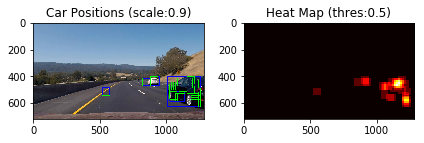

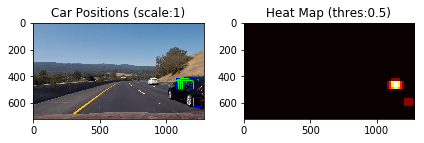

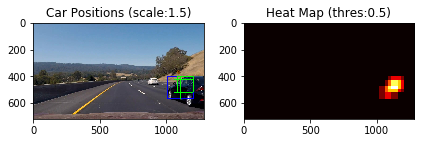

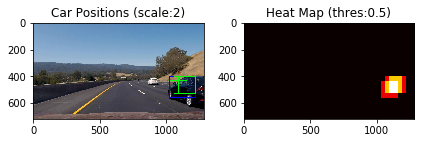

In [57]:
image = mpimg.imread('issue_images/org_video_image_20171229_07_41_59.jpg')
heatmaps = None
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=0.9)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=1)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=1.5)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=2)

i 0
start_y 400
stop_y 528
i 1
start_y 400
stop_y 656
1.2 Seconds to process a frame...


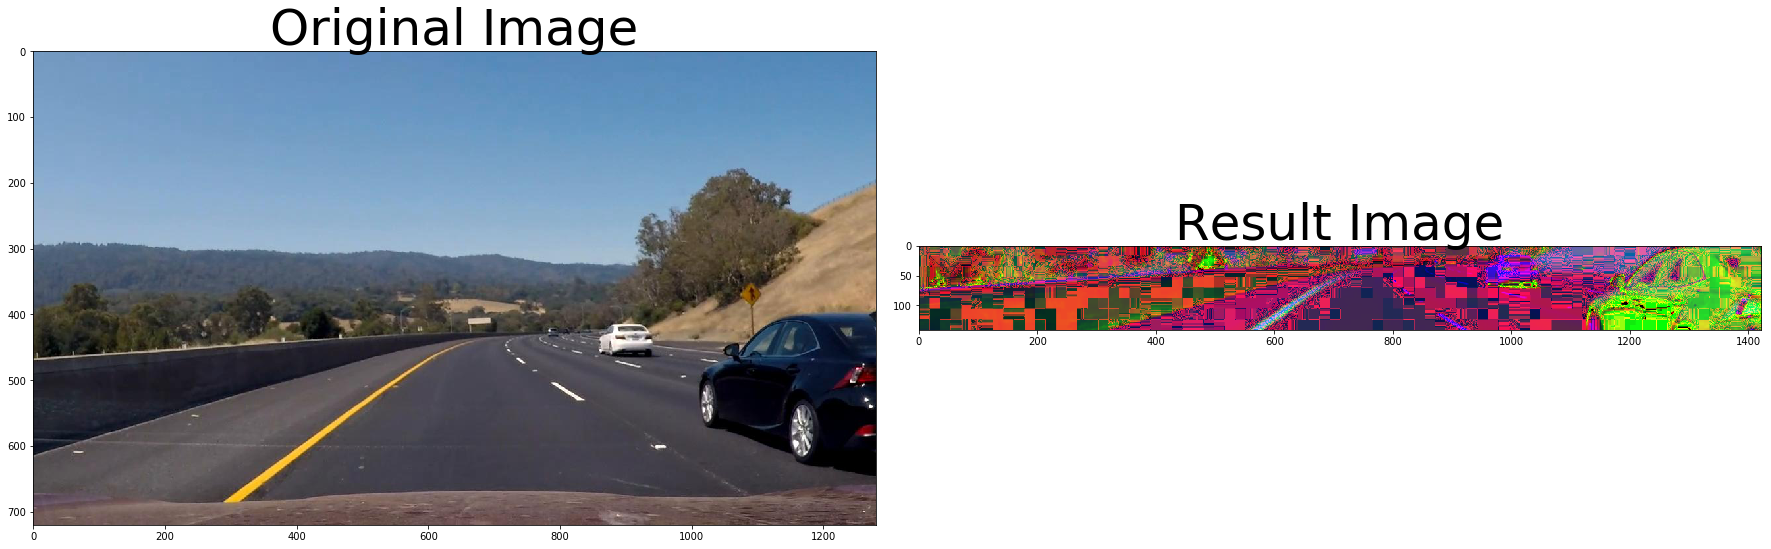

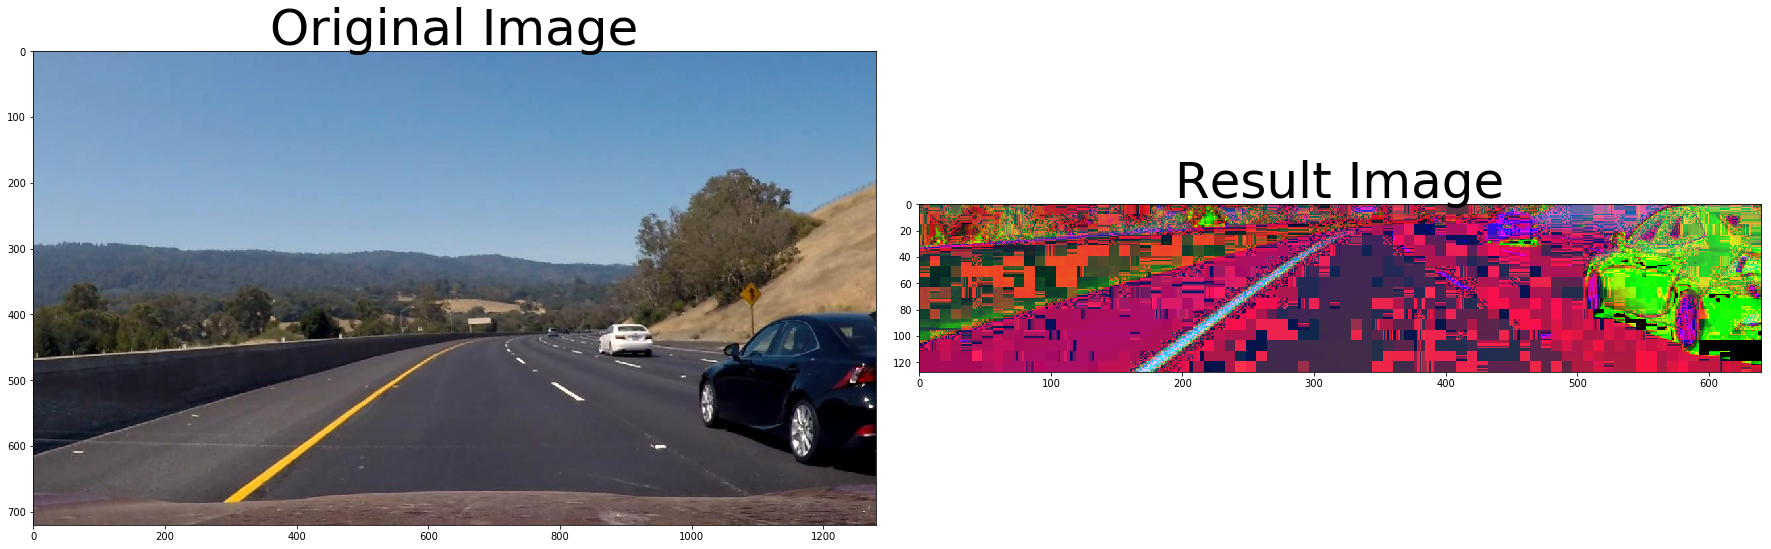

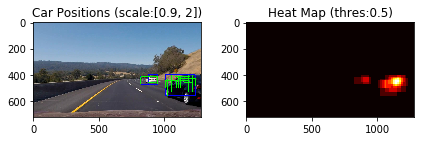

In [124]:
image = mpimg.imread('issue_images/org_video_image_20171229_07_41_59.jpg')
heatmaps = None
try_process_heatmap_hog_sub_sample_w_scales(image, config, threshold=0.5, scales=[0.9, 2])

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.33 Seconds to process a frame...
1.31 Seconds to process a frame...
0.55 Seconds to process a frame...
0.38 Seconds to process a frame...
1.3 Seconds to process a frame...
1.05 Seconds to process a frame...
0.53 Seconds to process a frame...
0.39 Seconds to process a frame...


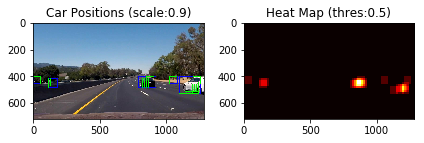

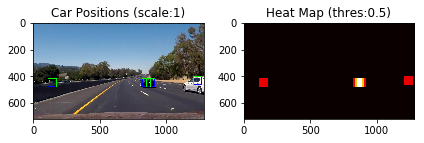

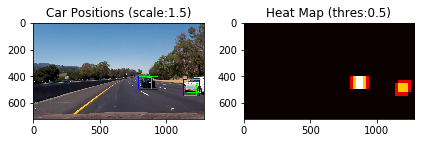

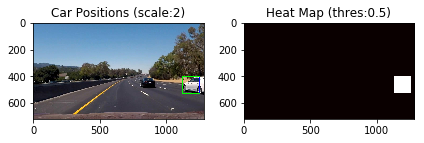

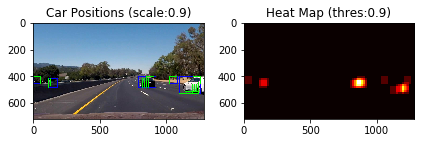

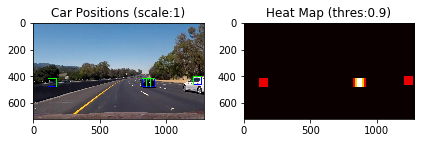

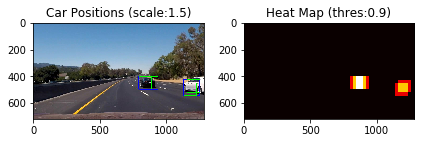

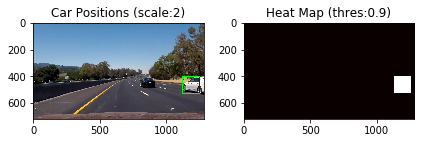

In [58]:
image = mpimg.imread('issue_images/org_video_image_20171229_07_44_15.jpg')

heatmaps = None
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=0.9)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=1)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=1.5)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=2)

try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=0.9)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=1)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=1.5)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=2)

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.46 Seconds to process a frame...
1.18 Seconds to process a frame...
1.01 Seconds to process a frame...
1.28 Seconds to process a frame...
0.53 Seconds to process a frame...
0.52 Seconds to process a frame...
0.45 Seconds to process a frame...
0.39 Seconds to process a frame...


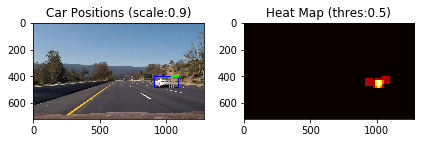

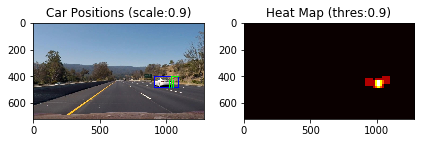

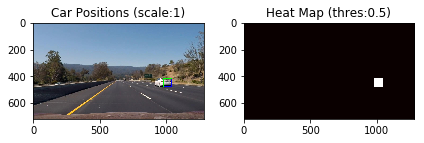

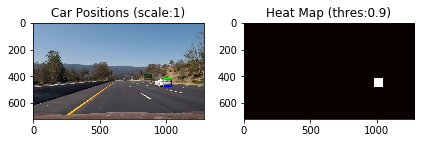

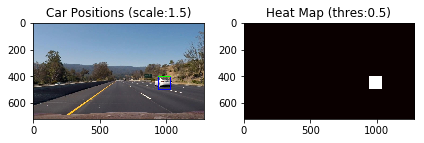

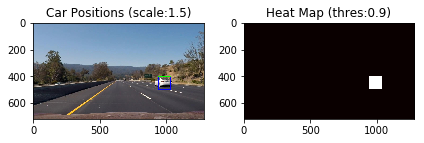

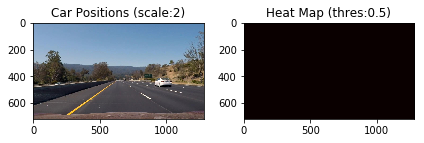

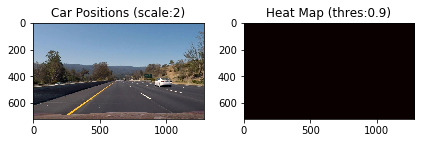

In [59]:
image = mpimg.imread('issue_images/org_video_image_20171229_07_40_21.jpg')

heatmaps = None
try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=0.9)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=0.9)

try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=1)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=1)

try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=1.5)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=1.5)

try_process_heatmap_hog_sub_sample(image, config, threshold=0.5, scale=2)
try_process_heatmap_hog_sub_sample(image, config, threshold=0.9, scale=2)

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here's a [link to my video result](./output_images/project_video_output.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]

In [60]:
DIR_ORG_VIDEO_SHOT = "./video_images/"
DIR_CVT_VIDEO_SHOT = "./converted_images/"
ORG_VIDEO_FILE_NAME = "org_video_image_"
CVT_VIDEO_FILE_NAME = "cvt_video_image_"
from PIL import Image
def save_image(image, dirname, filename):
    """save a image file"""    
    filepath = dirname + filename + datetime.now().strftime("%Y%m%d_%H_%M_%S.jpg")
    if not os.path.exists(filepath) :
        Image.fromarray(image).save(filepath)

In [150]:
def video_pipeline(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #result = process_heatmap_hog_sub_sample(image, config, threshold=video_threshold, scale=video_scale)
    result = process_heatmap_hog_sub_sample_w_scales(image, config, threshold=video_threshold, scales=video_scales,ystart=ystart, ystop=ystop)
    return result

In [151]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [166]:
video_threshold=0.5
#video_scale=2#0.9
video_scales=[1.5,2]#[0.9,2]#0.9
video_que_maxlen=3#10#5#1#20#10#5#10
print(video_scales)

[1.5, 2]


In [167]:
VIDEO_INPUT = 'test_video.mp4'
VIDEO_OUTPUT = 'output_images/test_video_out_th{}_scale{}_que{}.mp4'.format(video_threshold, video_scales, video_que_maxlen)

In [170]:
VIDEO_INPUT = 'project_video.mp4'
VIDEO_OUTPUT = 'output_images/project_video_out_th{}_scale{}_que{}.mp4'.format(video_threshold, video_scales, video_que_maxlen)

In [171]:
#VIDEO_INPUT = 'project_video.mp4'
#VIDEO_OUTPUT = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

print_global_variables()

clip1 = VideoFileClip(VIDEO_INPUT)

heatmaps = collections.deque(maxlen=video_que_maxlen)#10)#50)

white_clip = clip1.fl_image(video_pipeline)#NOTE: this function expects color images!!
%time white_clip.write_videofile(VIDEO_OUTPUT, audio=False)

heatmaps = None

color_space HSV
orient 9
pix_per_cell 8
cell_per_block 2
[MoviePy] >>>> Building video output_images/project_video_out_th0.5_scale[1.5, 2]_que3.mp4
[MoviePy] Writing video output_images/project_video_out_th0.5_scale[1.5, 2]_que3.mp4



  5%|████▎                                                                           | 67/1261 [00:30<09:09,  2.17it/s]


 11%|████████▍                                                                      | 135/1261 [01:02<09:34,  1.96it/s]


 16%|████████████▋                                                                  | 203/1261 [01:33<07:41,  2.29it/s]


 21%|████████████████▉                                                              | 271/1261 [02:05<07:11,  2.29it/s]


 27%|█████████████████████▏                                                         | 339/1261 [02:37<08:17,  1.85it/s]


 32%|█████████████████████████▍                                                     | 407/1261 [03:13<06:52,  2.07it/s]


 38%|█████████████████████████████▊                                                 | 475/1261 [03:47<07:27,  1.76it/s]


 43%|██████████████████████████████████                                             | 543/1261 [04:22<05:27,  2.19it/s]


 48%|██████████████████████████████████████▎                                        | 611/1261 [04:55<04:55,  2.20it/s]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [05:28<04:32,  2.14it/s]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [06:02<04:22,  1.96it/s]


 65%|███████████████████████████████████████████████████                            | 815/1261 [06:37<05:02,  1.48it/s]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [07:13<02:56,  2.14it/s]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [07:47<03:05,  1.67it/s]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [08:23<02:08,  1.89it/s]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [08:56<02:00,  1.45it/s]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [09:30<00:52,  2.04it/s]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [10:04<00:18,  2.08it/s]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:25<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_out_th0.5_scale[1.5, 2]_que3.mp4 

Wall time: 10min 27s


In [172]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(VIDEO_OUTPUT))

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

* Tendency per color of cars
* Scale modification for far small-looking car

| Source        | Destination   | Destination   | 
|:-------------:|:-------------:| -------------:|
|color_space  |'HSV'  | 'HLS' #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb |
|orient       |9  | HOG orientations |
|pix_per_cell |8  | HOG pixels per cell |
|cell_per_block |2  | HOG cells per block |
|hog_channel |"ALL" |1 # "ALL" #0 # Can be 0, 1, 2, or "ALL" |
|spatial_size |(16, 16)  | Spatial binning dimensions |
|hist_bins |16#32#16#32 #16  | Number of histogram bins |
|spatial_feat |True  | Spatial features on or off |
|hist_feat |True  | Histogram features on or off |
|hog_feat |True  | HOG features on or off |
|y_start_stop | [None, None]  | Min and max in y to search in slide_window() |